In [1]:
'''
This contains code for generating the following figures
    - "Explanation time as a function of model complexity. Varying number of trees T" 
    - "Explanation distance as a function of model complexity. Varying number of trees T"

Experiment results files needed: VaryNtrees

Results used in the paper are provided in "../results/final" if generating new results run each experiment and update the results paths below
'''
# path to each result file
results_path = "..//results/final/vary_ntrees.csv"

# path to output the figure
export_figures = True
output_dir = "./final/"
fig_save_name_1 = "vary_ntrees_time"
fig_save_name_2 = "vary_ntrees_dist"
fig_type = ".pdf"

In [2]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../"))
from dataset import DS_DIMENSIONS, DS_NAMES
from utilities.figure_tools import (get_latest_results_directory, load_results,
                                    make_fig_directory)

cmap = plt.get_cmap("Set1")
colors = cmap.colors
if export_figures and not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [3]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
marker_size = 12
line_width = 4
ds_colors = {
    "cancer": colors[0],
    "glass": colors[1],
    "magic": colors[2],
    "spambase": colors[3],
    "vertebral": colors[4]
}
epl_colors = {
    "AFT": colors[0],
    "FACETIndex": colors[1],
    "OCEAN": colors[2],
    "RFOCSE": colors[3],
    "MACE": colors[4]
}
explainer_markers = {
    "AFT": "o",
    "FACETIndex": "^",
    "OCEAN": "s",
    "RFOCSE": "v",
    "MACE": "D"
}
marker_sizes = {
    "AFT": marker_size,
    "FACETIndex": marker_size,
    "OCEAN": marker_size,
    "RFOCSE": marker_size,
    "MACE": marker_size
}
pretty_explainer_names = {
    "AFT": "AFT",
    "FACETIndex": "FACET",
    "OCEAN": "OCEAN",
    "RFOCSE": "RFOCSE",
    "MACE": "MACE",
}

all_results = pd.read_csv(results_path).groupby(["dataset", "explainer", "n_trees"], as_index=False).mean()
found_explainers = all_results["explainer"].unique()
all_explainers = ["FACETIndex", "OCEAN", "MACE", "RFOCSE", "AFT"]
explainers = []
for expl in all_explainers:
    if expl in found_explainers:
        explainers.append(expl)
plot_fontsize = 20
all_results.head()

,dataset,explainer,n_trees,iteration,max_depth,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain
0,cancer,FACETIndex,10,4.5,5.0,0.946491,0.940244,0.908325,0.923360,1.0,0.153822,4.325,4.778947,0.400329,0.020016,20.0
1,cancer,FACETIndex,50,4.5,5.0,0.950000,0.944800,0.913592,0.928486,1.0,0.295229,10.005,16.597418,2.257733,0.112887,20.0
2,cancer,FACETIndex,100,4.5,5.0,0.954386,0.949355,0.921485,0.934777,1.0,0.351798,13.085,24.791025,2.964173,0.148209,20.0
3,cancer,FACETIndex,200,4.5,5.0,0.952632,0.950321,0.915766,0.932107,1.0,0.408269,16.375,40.547195,3.467154,0.173358,20.0
4,cancer,FACETIndex,300,4.5,5.0,0.951754,0.946068,0.918091,0.931277,1.0,0.432710,18.155,56.095890,3.744109,0.187205,20.0


In [4]:
def render_plot_ax(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None, ylog=False, yticks_multi=None, yrange_multi=None, ytick_format="{:.2f}"):
    results = all_results.groupby(["dataset", "explainer"], as_index=False).mean()

    datasets = all_results["dataset"].unique()
    fig = plt.figure(figsize=[32, 4])
    ax = fig.subplots(nrows=1, ncols=5, sharex="all") #nrows=1, ncols=5, sharex="all")
    xticks = np.arange(0, 501, 100)
    xtick_labels = ["{:d}".format(_) for _ in xticks]
    
    for i in range(len(datasets)):
        ds = datasets[i]
        is_ds = all_results["dataset"] == ds
        for expl in explainers:
            is_expl = all_results["explainer"] == expl
            matching_rows = is_ds & is_expl
            ax[i].plot(all_results[matching_rows][xfeature], all_results[matching_rows][yfeature], label=expl, marker=explainer_markers[expl], lw=line_width, ms=marker_size)
            
            ax[i].tick_params(axis='both', which='major', labelsize=plot_fontsize)
            if xrange is not None:
                ax[i].set_xticks(xticks)
                ax[i].set_xticklabels(xtick_labels, fontdict={"horizontalalignment": "center"}, rotation=0)
            # optional letter: "(" + chr(ord('a')+i) + ") " 
            ax[i].set_title("({:s}) {:s}".format(chr(ord('a')+i), datasets[i].upper()), fontdict={"fontsize": plot_fontsize}) 
            if xrange is not None:
                ax[i].set_xlim(xrange)
            if yticks_multi is not None:
                ax[i].set_yticks(yticks_multi[i])
                ax[i].set_yticklabels([ytick_format.format(_) for _ in yticks_multi[i]])
            if yrange_multi is not None:
                bottom = yrange_multi[i][0]
                top = yrange_multi[i][1]
                if bottom is not None:
                    ax[i].set_ylim(bottom=bottom)
                if top is not None:
                    ax[i].set_ylim(top=top)


    ax[0].set_ylabel(ylabel, fontsize=plot_fontsize)
    
    # ax[0].set_yticklabels(tick_labels)
    lines, labels = ax[0].get_legend_handles_labels()
    fig.subplots_adjust(wspace=0.18)
    legend_labels = [pretty_explainer_names[_] for _ in labels]
    fig.legend(lines,
        legend_labels, loc="center left", bbox_to_anchor=(0.025, 0.5), handletextpad=0.5, columnspacing=1, handlelength=1.5, prop={"size": plot_fontsize}
    )
    if save_name is not None:
        fig.savefig(output_dir + save_name + fig_type, bbox_inches="tight")

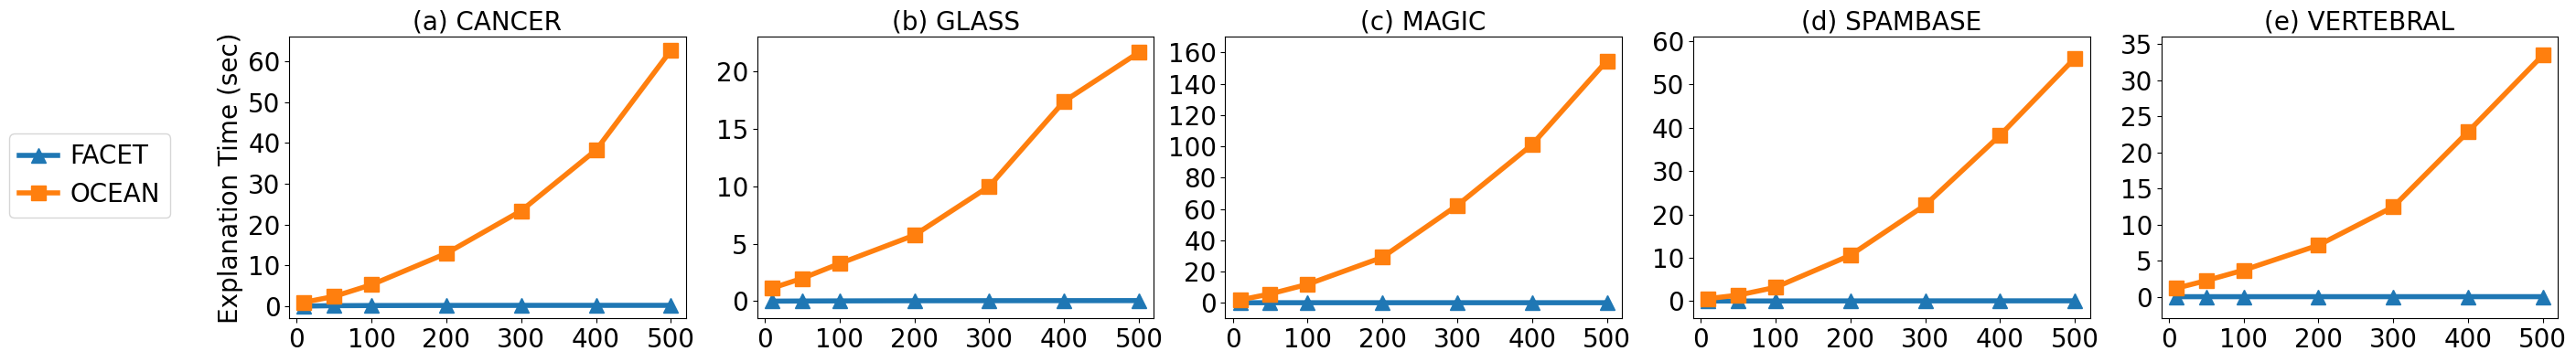

In [5]:
# sample time vs number of trees
yticks_multi = [np.arange(0, 61, 10,), np.arange(0, 26, 5), np.arange(0, 161, 20), np.arange(0, 61, 10), np.arange(0, 36, 5)]
yrange_multi = [[-3, 66], [-1.5, 23], [-10, 170], [-4, 61], [-3, 36]]
render_plot_ax(xfeature="n_trees", yfeature="sample_time", xlabel="T (Number of Trees)", ylabel="Explanation Time (sec)", title="Explanation Time vs Num Trees", save_name=fig_save_name_1, xrange=[-10, 520], yrange_multi=yrange_multi, yticks_multi=yticks_multi, ytick_format="{:d}")

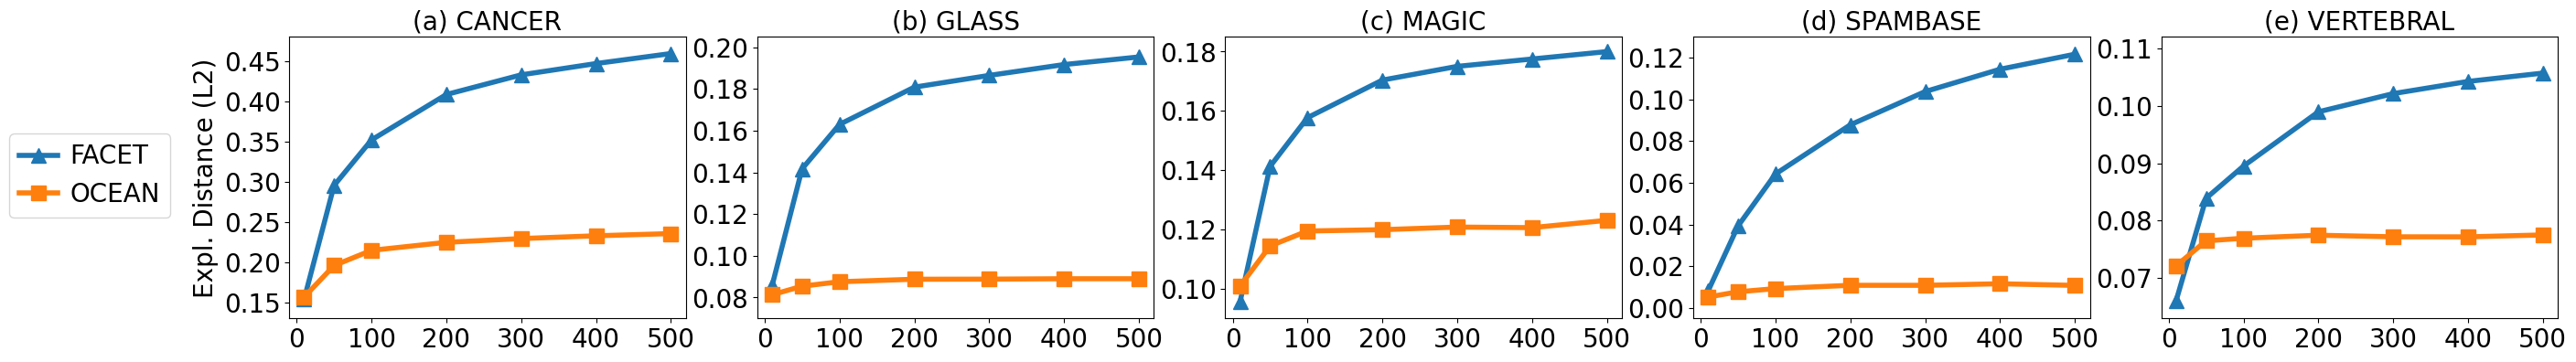

In [6]:
yticks_multi = [np.arange(0.15, 0.45, 0.05), np.arange(0.08, 0.21, 0.02), np.arange(0.1, 0.19, 0.02), np.arange(0, 0.13, 0.02), np.arange(0.06, 0.12, 0.01)]
yrange_multi = [[0.13, 0.48], [0.07, 0.205], [0.09, 0.185], [-0.005, 0.13], [0.063, 0.112]]
render_plot_ax(xfeature="n_trees", yfeature="avg_dist", xlabel="T (Number of Trees)", ylabel="Expl. Distance (L2)", title="Average Distance vs Num Trees", save_name=fig_save_name_2, xrange=[-10, 520], yticks_multi=yticks_multi, yrange=[None, None], yrange_multi=yrange_multi)

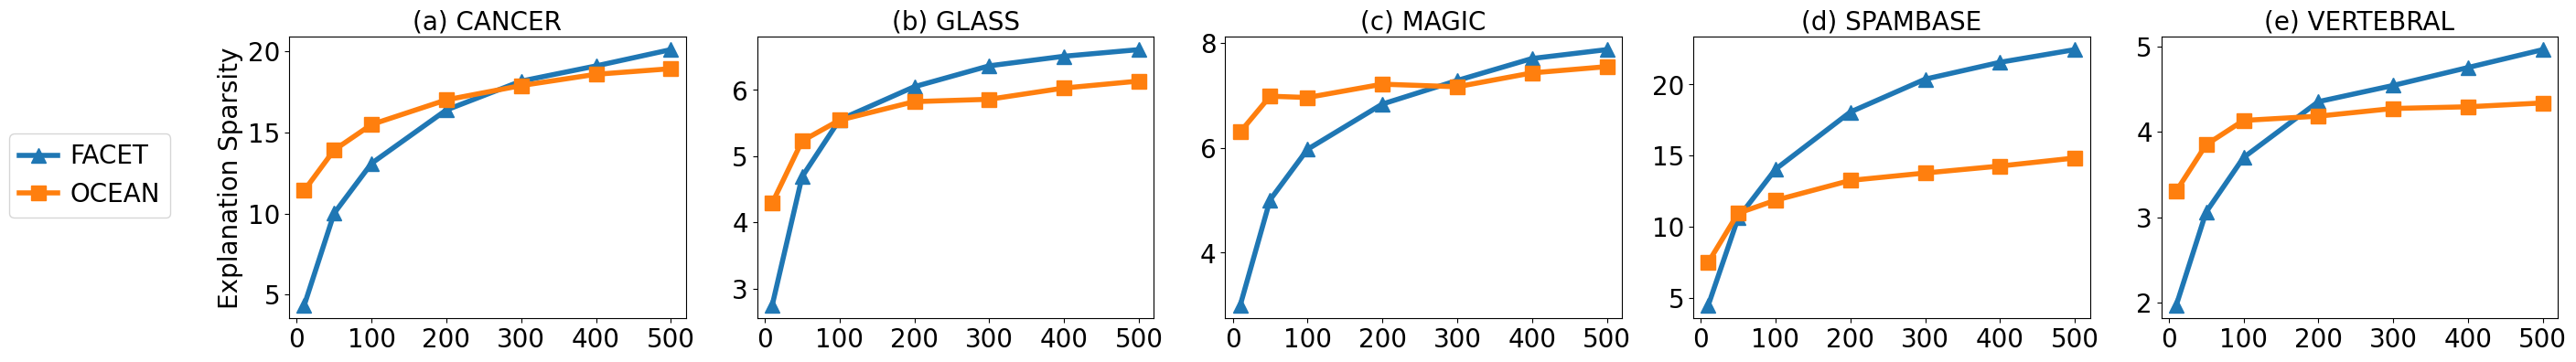

In [7]:
# sample time vs number of trees
yticks_multi = None
yrange_multi = None
render_plot_ax(xfeature="n_trees", yfeature="avg_length", xlabel="T (Number of Trees)", ylabel="Explanation Sparsity", title="Sparsity vs Num Trees", save_name=None, xrange=[-10, 520], yrange_multi=yrange_multi, yticks_multi=yticks_multi, ytick_format="{:d}")